In [1]:
# RECOMMENDATIONS ON USERS & THEIR RATINGS ON BOOKS DATASET

In [2]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [3]:
user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

In [4]:
user.head()

userID                            Location   Age
0       1                  nyc, new york, usa   NaN
1       2           stockton, california, usa  18.0
2       3     moscow, yukon territory, russia   NaN
3       4           porto, v.n.gaia, portugal  17.0
4       5  farnborough, hants, united kingdom   NaN

In [5]:
rating.head()

userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6

In [6]:
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)

In [7]:
df.head()

userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5
3       8  0060973129           0
4       8  0374157065           0

In [8]:
df.shape

(1149780, 3)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


In [10]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :])

Dataset shape: (1149780, 3)
-Dataset examples-
         userID        ISBN  bookRating
0             2  0195153448           0
200000    48494  0871233428           0
400000    98391  0670032549          10
600000   147513  0470832525           5
800000   196502  0590431862           0
1000000  242157  0732275865           0


## EDA

### Ratings Distribution

In [11]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
# 62% of all ratings are 0 and very few ratings are 1 / 2 / 3. Low rating indicates those books are bad

In [ ]:
# Ratings Distribution by Book

In [11]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [12]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

In [12]:
# Most books received < 5 ratings. Most rated books received 2.5 ratings

In [13]:
#Ratings Distribution by User

In [14]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [15]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105111  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

In [ ]:
# Most users gace 5 ratings and few users have many ratings. Most effective user -13,602 ratings

In [16]:
# Reduce the dimensionality of dataset by filtering out the rated movies and rarely rated users

In [17]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


In [18]:
# We used Surprise Library Package 

In [19]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

In [20]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [21]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [22]:
surprise_results

test_rmse   fit_time  test_time
Algorithm                                       
BaselineOnly      3.379042   0.263624   0.249336
CoClustering      3.467093   2.404041   0.237010
SlopeOne          3.477588   0.726722   3.393926
KNNWithMeans      3.488797   0.692803   4.329763
KNNBaseline       3.493671   0.919198   5.169509
KNNWithZScore     3.509553   0.775904   4.650231
SVD               3.542911   4.424144   0.296554
KNNBasic          3.730927   0.644616   3.848401
SVDpp             3.782852  98.648544   4.078760
NMF               3.852360   4.858021   0.273599
NormalPredictor   4.673243   0.133964   0.297889

In [ ]:
# Apply BaselineOnly algorithm to get the best RMSE values using Alternating Least Squares

In [20]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.37390979, 3.38228761, 3.37046039]),
 'fit_time': (0.14757299423217773, 0.17157196998596191, 0.17652630805969238),
 'test_time': (0.24836945533752441, 0.1685187816619873, 0.24434709548950195)}

In [ ]:
# We will perform train ,test & split of the trainset and testset and use the accuracy metrics of RMSE. 
#We will use Fit() to train the algorithm on trainset and use Test() method which will return Predictions from testset. 

In [21]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3620


3.3619755569125136

In [22]:
# dump.dump('./dump_file', predictions, algo)
# predictions, algo = dump.load('./dump_file')

In [23]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.

In [ ]:
#Inspect our predictions 

In [24]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [25]:
df.head()

uid         iid   rui       est                    details    Iu   Ui  \
0   23768  0446610542   0.0  0.794492  {'was_impossible': False}   332   67   
1  178199  0679459626   8.0  5.233657  {'was_impossible': False}    57   15   
2  123257  0439139597  10.0  7.739309  {'was_impossible': False}    21   87   
3   11676  067976402X  10.0  4.694851  {'was_impossible': False}  1164  256   
4   92810  0452264464   7.0  4.133868  {'was_impossible': False}    53   63   

        err  
0  0.794492  
1  2.766343  
2  2.260691  
3  5.305149  
4  2.866132

In [26]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [27]:
best_predictions

uid         iid  rui  est                    details   Iu   Ui  err
17170  203968  0449206475  0.0  0.0  {'was_impossible': False}   87   31  0.0
1471    24921  0971880107  0.0  0.0  {'was_impossible': False}   94  613  0.0
22881   36836  0446353205  0.0  0.0  {'was_impossible': False}  169   41  0.0
9372   266226  0446365505  0.0  0.0  {'was_impossible': False}  129   51  0.0
22947   79186  0553582135  0.0  0.0  {'was_impossible': False}   89   64  0.0
32976   51094  0451200101  0.0  0.0  {'was_impossible': False}   59   20  0.0
16210  102967  0446363669  0.0  0.0  {'was_impossible': False}  400   36  0.0
1452   217375  0553580884  0.0  0.0  {'was_impossible': False}  257   35  0.0
4859    23768  0786866276  0.0  0.0  {'was_impossible': False}  332   33  0.0
9348   212898  0061092045  0.0  0.0  {'was_impossible': False}  189   28  0.0

The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 26 to 146, they are not really small, meaning that significant number of users have rated the target book.

In [28]:
worst_predictions

uid         iid   rui       est                    details   Iu  \
8435   245963  0425170349  10.0  0.215035  {'was_impossible': False}  150   
4642   205735  0373825013  10.0  0.145192  {'was_impossible': False}   73   
3086   238781  0345443284  10.0  0.123522  {'was_impossible': False}  178   
29602   11601  0375703063  10.0  0.110103  {'was_impossible': False}  173   
34985  260897  0374129983  10.0  0.098797  {'was_impossible': False}  114   
2220    73394  0345387651  10.0  0.055635  {'was_impossible': False}  225   
34886   55548  0553278398  10.0  0.000000  {'was_impossible': False}  121   
28148  200674  0451160533  10.0  0.000000  {'was_impossible': False}  147   
20432   24921  0440236665  10.0  0.000000  {'was_impossible': False}   94   
6792   115490  081297106X  10.0  0.000000  {'was_impossible': False}  168   

        Ui        err  
8435    48   9.784965  
4642    73   9.854808  
3086   152   9.876478  
29602   75   9.889897  
34985   49   9.901203  
2220   116   9.944365  
34886   25  10.000000  
28148   29  10.000000  
20432   24  10.000000  
6792    45  10.000000

The worst predictions look pretty surprise. Let's look in more details of the last one ISBN "055358264X", the book was rated by 47 users, user "26544" rated 10, our BaselineOnly algorithm predicts 0.

In [29]:
df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].describe()

count    60.000000
mean      1.283333
std       2.969287
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.000000
Name: bookRating, dtype: float64

<IPython.core.display.Javascript object>


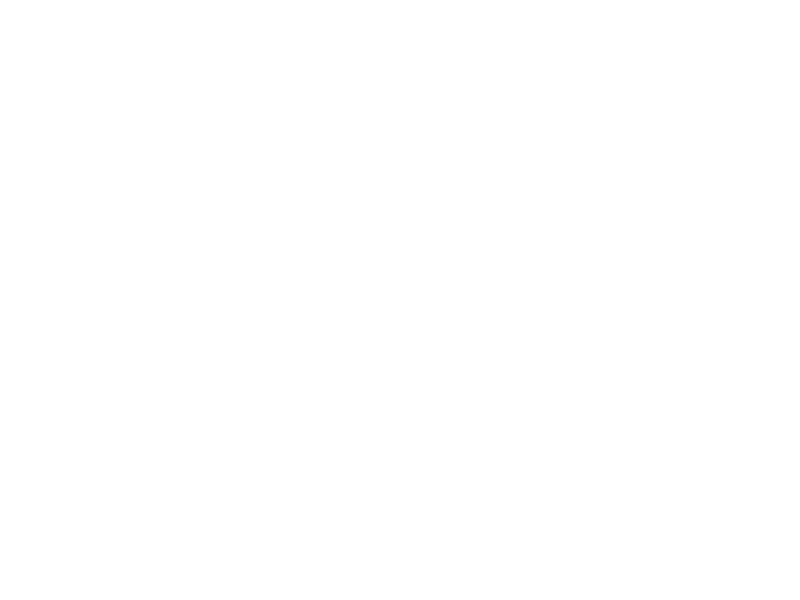

In [30]:
import matplotlib.pyplot as plt
%matplotlib notebook

df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show();

In [ ]:
#It turns out to be "0", in another word, most of the users rated this book "0", 
#only very few users rated "10". Same with the other predictions in "worst predictions" list. 
#It seems that for each prediction, the users are some kind of outsiders.